In [1]:
# Core jax
import jax.numpy as np
import jax.random as jr
from jax.scipy.stats import poisson

# ∂Lux
import dLux as dl

# Optimisation
import zodiax as zdx
import optax

# Plotting and visualisation
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["text.usetex"] = 'true'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 120

### Get the MNIST data set

In [2]:
import tensorflow_datasets as tfds

mnist_data, _ = tfds.load(
    name="mnist", batch_size=-1, with_info=True, as_supervised=True
)
mnist_data = tfds.as_numpy(mnist_data)
data_train, data_test = mnist_data["train"], mnist_data["test"]

def one_hot_encode(x, k, dtype=np.float32):
    "Create a one-hot encoding of x of size k."
    return np.array(x[:, None] == np.arange(k), dtype)

def prepare_data(dataset: tuple, num_categories=10):
    X, y = dataset
    y = one_hot_encode(y, num_categories)

    num_examples = X.shape[0]
    num_pixels = 28 * 28
    X = X.reshape(num_examples, num_pixels)
    X = X / 255.0

    return np.array(X), np.array(y), num_examples

def batch_data(rng_key, data, batch_size, data_size):
    """Return an iterator over batches of data."""
    while True:
        _, rng_key = jr.split(rng_key)
        idx = jr.choice(
            key=rng_key, a=np.arange(data_size), shape=(batch_size,)
        )
        minibatch = tuple(elem[idx] for elem in data)
        yield minibatch

X_train, y_train, N_train = prepare_data(data_train)
X_test, y_test, N_test = prepare_data(data_test)

### Define the regularisers

In [3]:
def ent(array, eps=1e-10):
    """calcualtes the entropy of the array"""
    return -np.sum(array * np.log(array + eps))

def total_variation(array):
    """calcualtes the total variation of the array"""
    array = np.pad(array, 2)
    diff_y = np.abs(array[1:, :] - array[:-1, :]).sum()
    diff_x = np.abs(array[:, 1:] - array[:, :-1]).sum()
    return diff_x + diff_y

def quadratic_variation(array):
    """calcualtes the quadratic variation of the array"""
    array = np.pad(array, 2)
    diff_y = np.square(array[1:, :] - array[:-1, :]).sum()
    diff_x = np.square(array[:, 1:] - array[:, :-1]).sum()
    return diff_x + diff_y


### Create our resolved source with the MNIST digit as the distribution

In [4]:
# Distribution
distribution = X_train[2].reshape(28, 28)
distribution /= distribution.sum()

# Distributions
N = 5
distributions = X_train[:N].reshape(N, 28, 28)
distributions /= distributions.sum((-1, -2), keepdims=True)

# Source and spectrum
flux = 1e6
wavels = np.linspace(5e-7, 6e-7, 5)
source = dl.ResolvedSource(flux=flux, distribution=distribution, wavelengths=wavels)

### Set up the optical system (Using Toliman as an example because of its funky interferometric-like psf)

In [5]:
import dLux.utils as dlu

# Wavefront properties
diameter = 0.1
wf_npixels = 256

# Construct an aperture with a single spider as the asymmetry
oversample = 1
coords = dlu.pixel_coords(oversample * wf_npixels, diameter)
circle = dlu.circle(coords, diameter / 2)
spider = dlu.spider(coords, diameter / 6, [90])
transmission = dlu.combine([circle, spider], oversample)

# Toliman mask for funk psf
phase_mask = np.load("diffractive_pupil.npy")
mask = dl.utils.phase2opd(phase_mask, wavels.mean())
mask_layer = dl.Optic(opd=mask)

# Zernike aberrations
zernike_indexes = np.arange(4, 11)
coeffs = 2e-8 * jr.normal(jr.PRNGKey(0), zernike_indexes.shape)
coords = dlu.pixel_coords(wf_npixels, diameter)
basis = dlu.zernike_basis(zernike_indexes, coords, diameter)

# Get the Toliman mask
mask = np.load("diffractive_pupil.npy")
mask = dlu.downsample(mask, mask.shape[0] // wf_npixels)
mask = mask.at[np.where(mask <= 0.5)].set(0.0)
mask = mask.at[np.where(mask > 0.5)].set(1.0)
opd = dlu.phase2opd(mask * np.pi, wavels.mean())

layers = [
    ("aperture", dl.layers.BasisOptic(basis, transmission, coeffs, normalise=True)),
    ("pupil", dl.Optic(opd=opd)),
]

# psf params
psf_npixels = 128
psf_pixel_scale = 0.375  # arcsec per pix

# Construct Optics
optics = dl.AngularOpticalSystem(
    wf_npixels, diameter, layers, psf_npixels, psf_pixel_scale, oversample
)

tel = dl.Telescope(optics, source)

### Look at out model and data

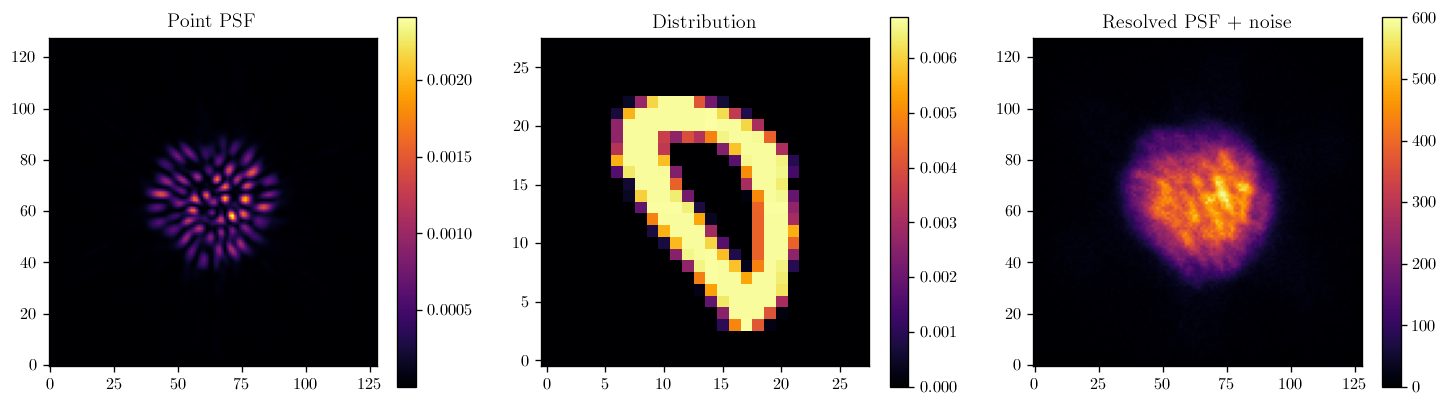

In [6]:
psf = optics.model(source)
point_psf = optics.propagate(source.wavelengths)
data = jr.poisson(jr.PRNGKey(1), psf)

# Plot two images
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Point PSF")
plt.imshow(point_psf)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Distribution")
plt.imshow(distribution)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Resolved PSF + noise")
plt.imshow(data)
plt.colorbar()
plt.show()

### Define the loss and optimisers (note we are defaulting to no regularisation for now)

In [7]:
params = [
    "position", # Source position
    "aperture.coefficients", # zernike coefficients
    "distribution", # Source distribution
]

optimisers = [
    optax.adam(1e-8), # Source position
    optax.adam(1e-8), # zernike coefficients
    optax.adam(1e-4), # Source distribution
]

def prior(model, alpha=0, beta=0, gamma=0):
    distribution = model.source.distribution
    prior = alpha * ent(distribution)
    prior += beta * total_variation(distribution)
    prior += gamma * quadratic_variation(distribution)
    return prior

def likelihood(model, data):
    psf = model.model()
    return -poisson.logpmf(data, psf).sum()

@zdx.filter_jit
@zdx.filter_value_and_grad(params)
def loss_fn(model, data, alpha=0, beta=0, gamma=0):
    loss = likelihood(model, data)
    loss += prior(model, alpha, beta, gamma)
    return loss

### Compile the model

In [8]:
%%time
loss, grads = loss_fn(tel, data)
print("Initial Loss: {}".format(loss))

Initial Loss: 43981.48828125
CPU times: user 443 ms, sys: 33.3 ms, total: 477 ms
Wall time: 351 ms


### Initialise our naive model (ie no aberrations and uniform distribution) and optimise it

In [9]:
# Initialise a fresh model
starting_aberrations = np.zeros_like(tel.aperture.coefficients)
starting_distribution = np.ones_like(tel.distribution)
starting_distribution /= starting_distribution.sum()

# Set the initial model
model = tel.set(
    ["aperture.coefficients", "distribution"],
    [starting_aberrations, starting_distribution],
)

# Get the optimisers
optim, opt_state = zdx.get_optimiser(model, params, optimisers)

# Optimise!
losses, models_out = [], [model]
with tqdm(range(250),desc='Gradient Descent') as t:
    for i in t: 
        # Update the model
        loss, grads = loss_fn(model, data)
        updates, opt_state = optim.update(grads, opt_state)
        model = zdx.apply_updates(model, updates)

        # Re-normalise the distribution to unity power
        dist = np.maximum(model.distribution, 0) # Ensure no negative values
        dist /= dist.sum() # Normalise to unity

        model = model.set("distribution", dist)

        # Save the outputs
        models_out.append(model)
        losses.append(loss)
        t.set_description("Loss: {:.3f}".format(loss.mean())) # update the progress bar

Gradient Descent:   0%|          | 0/250 [00:00<?, ?it/s]

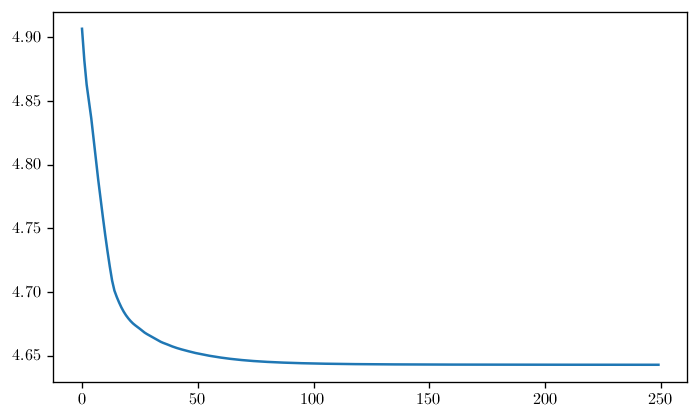

In [10]:
losses = np.array(losses)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(np.log10(losses))

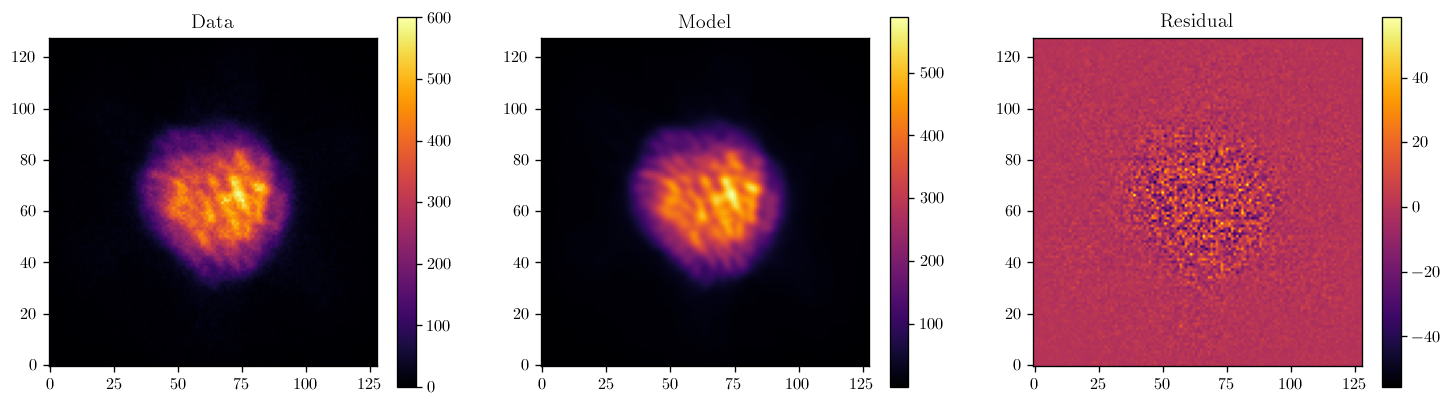

In [11]:
image = models_out[-1].model()

# Plot two images
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("Data")
plt.imshow(data)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Model")
plt.imshow(image)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(data - image)
plt.colorbar()
plt.show()

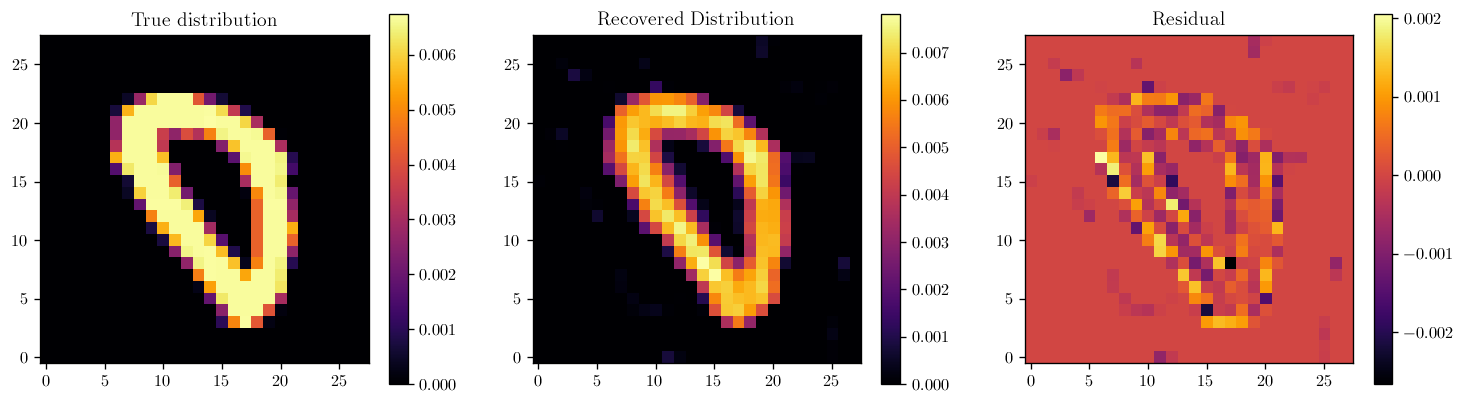

In [12]:
dist_out = models_out[-1].distribution

# Plot two images
plt.figure(figsize=(15, 4))
plt.subplot(1, 3, 1)
plt.title("True distribution")
plt.imshow(distribution)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.title("Recovered Distribution")
plt.imshow(dist_out)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.title("Residual")
plt.imshow(distribution - dist_out)
plt.colorbar()
plt.show()

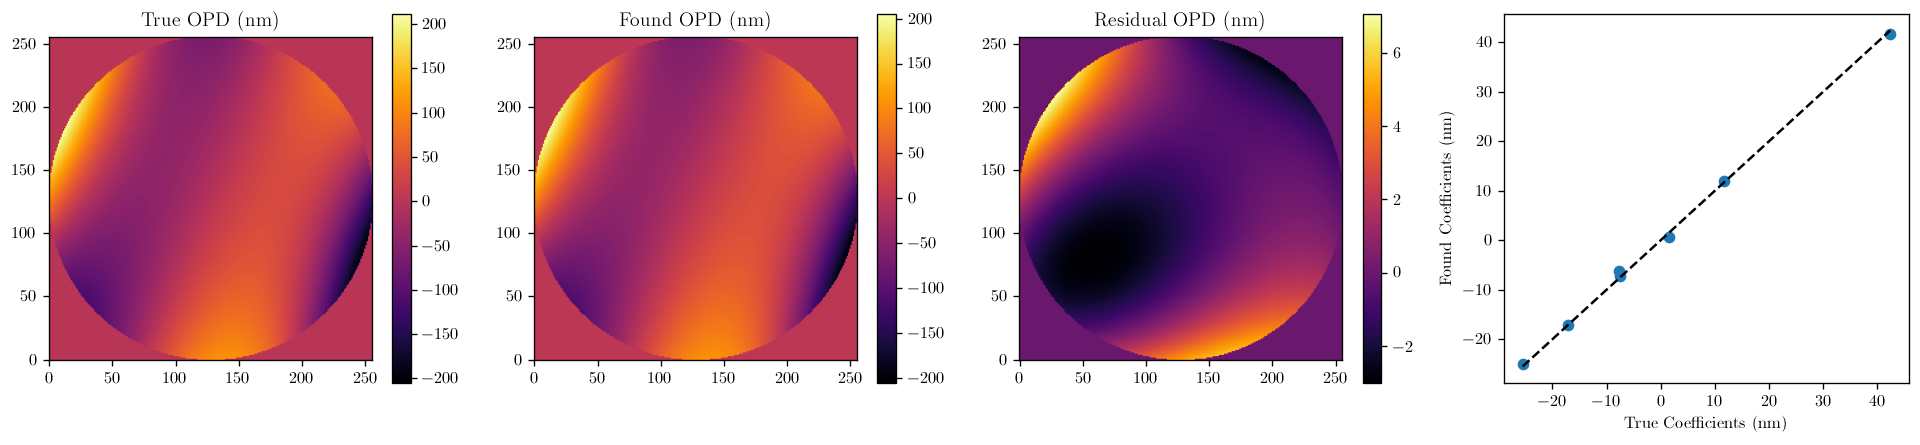

In [13]:
final_model = models_out[-1]
true_opd = tel.aperture.eval_basis()*1e9

found_opd = final_model.aperture.eval_basis()*1e9
residual_opd = true_opd - found_opd

true_coeffs = tel.aperture.coefficients * 1e9
found_coeffs = final_model.aperture.coefficients * 1e9

plt.figure(figsize=(20, 4))
plt.subplot(1, 4, 1)
plt.title("True OPD (nm)")
plt.imshow(true_opd)
plt.colorbar()

plt.subplot(1, 4, 2)
plt.title("Found OPD (nm)")
plt.imshow(found_opd)
plt.colorbar()

plt.subplot(1, 4, 3)
plt.title("Residual OPD (nm)")
plt.imshow(residual_opd)
plt.colorbar()

plt.subplot(1, 4, 4)
plt.scatter(true_coeffs, found_coeffs)
coeff_range = np.linspace(true_coeffs.min(), true_coeffs.max())
plt.plot(coeff_range, coeff_range, c='k', linestyle='--')
plt.xlabel("True Coefficients (nm)")
plt.ylabel("Found Coefficients (nm)")
plt.show()